In [1]:
# DR LI WAN | UNIVERSITY OF CAMBRIDGE
# MR SHANTONG WANG
# MS TIANYUAN WANG

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.lines as mlines
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from matplotlib import cm

import plotly.express as px
import networkx as nx
from pyproj import Proj, transform 
from mpl_toolkits.basemap import Basemap as Basemap

import geopandas as gpd  # gpd.__version__  # gpd.show_versions()
import shapely
import shapely.geometry as geom
from shapely.geometry import LineString

In [2]:
from map_function import read_csv, flow_map

In [3]:
df = read_csv('with nodes coordinates.csv')
df

(2211, 9)


,OBJECTID,length_unit,magnitude,coord_x1,coord_y1,name_x1y1,coord_x2,coord_y2,name_x2y2
0,1,364.48618,3384.0,0.101681,52.159237,1a,0.098907,52.158174,1b
1,2,287.94352,3384.0,0.098907,52.158174,2a,0.096869,52.157197,2b
2,3,21.26571,826.0,0.102216,52.160129,3a,0.102196,52.160013,3b
3,4,84.85154,3797.0,0.102149,52.159589,4a,0.101681,52.159237,4b
4,5,77.06397,826.0,0.102196,52.160013,5a,0.102149,52.159589,5b
...,...,...,...,...,...,...,...,...,...
2206,2207,19.55846,2.0,0.049261,52.293250,2207a,0.049420,52.293205,2207b
2207,2208,0.13286,5.0,0.055653,52.291566,2208a,0.055654,52.291566,2208b
2208,2209,177.76883,3.0,0.054186,52.291953,2209a,0.055653,52.291566,2209b
2209,2210,17.90372,1.0,0.049420,52.293205,2210a,0.049568,52.293166,2210b


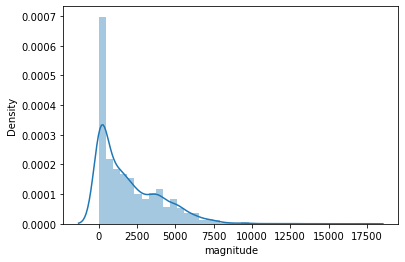

In [4]:
ax = sns.distplot(df['magnitude'])

In [11]:
title = 'Cambridge Flow Map'
#subtitle = 'No. of commuters by mode - xxx in year xxx'

date = '22 Aug'
time = 'xxpm'
vehicle = 'xx'
location = 'Cambridge'

subtitle = location+' '+date+' '+time


cutoff1 = 0
cutoff2 = 1
cutoff3 = 100
cutoff4 = 2000
cutoff5 = 5000
color1 = 'lightgreen'
color2 = 'dodgerblue'
color3 = 'khaki'
color4 = 'orange'
color5 = 'orangered'

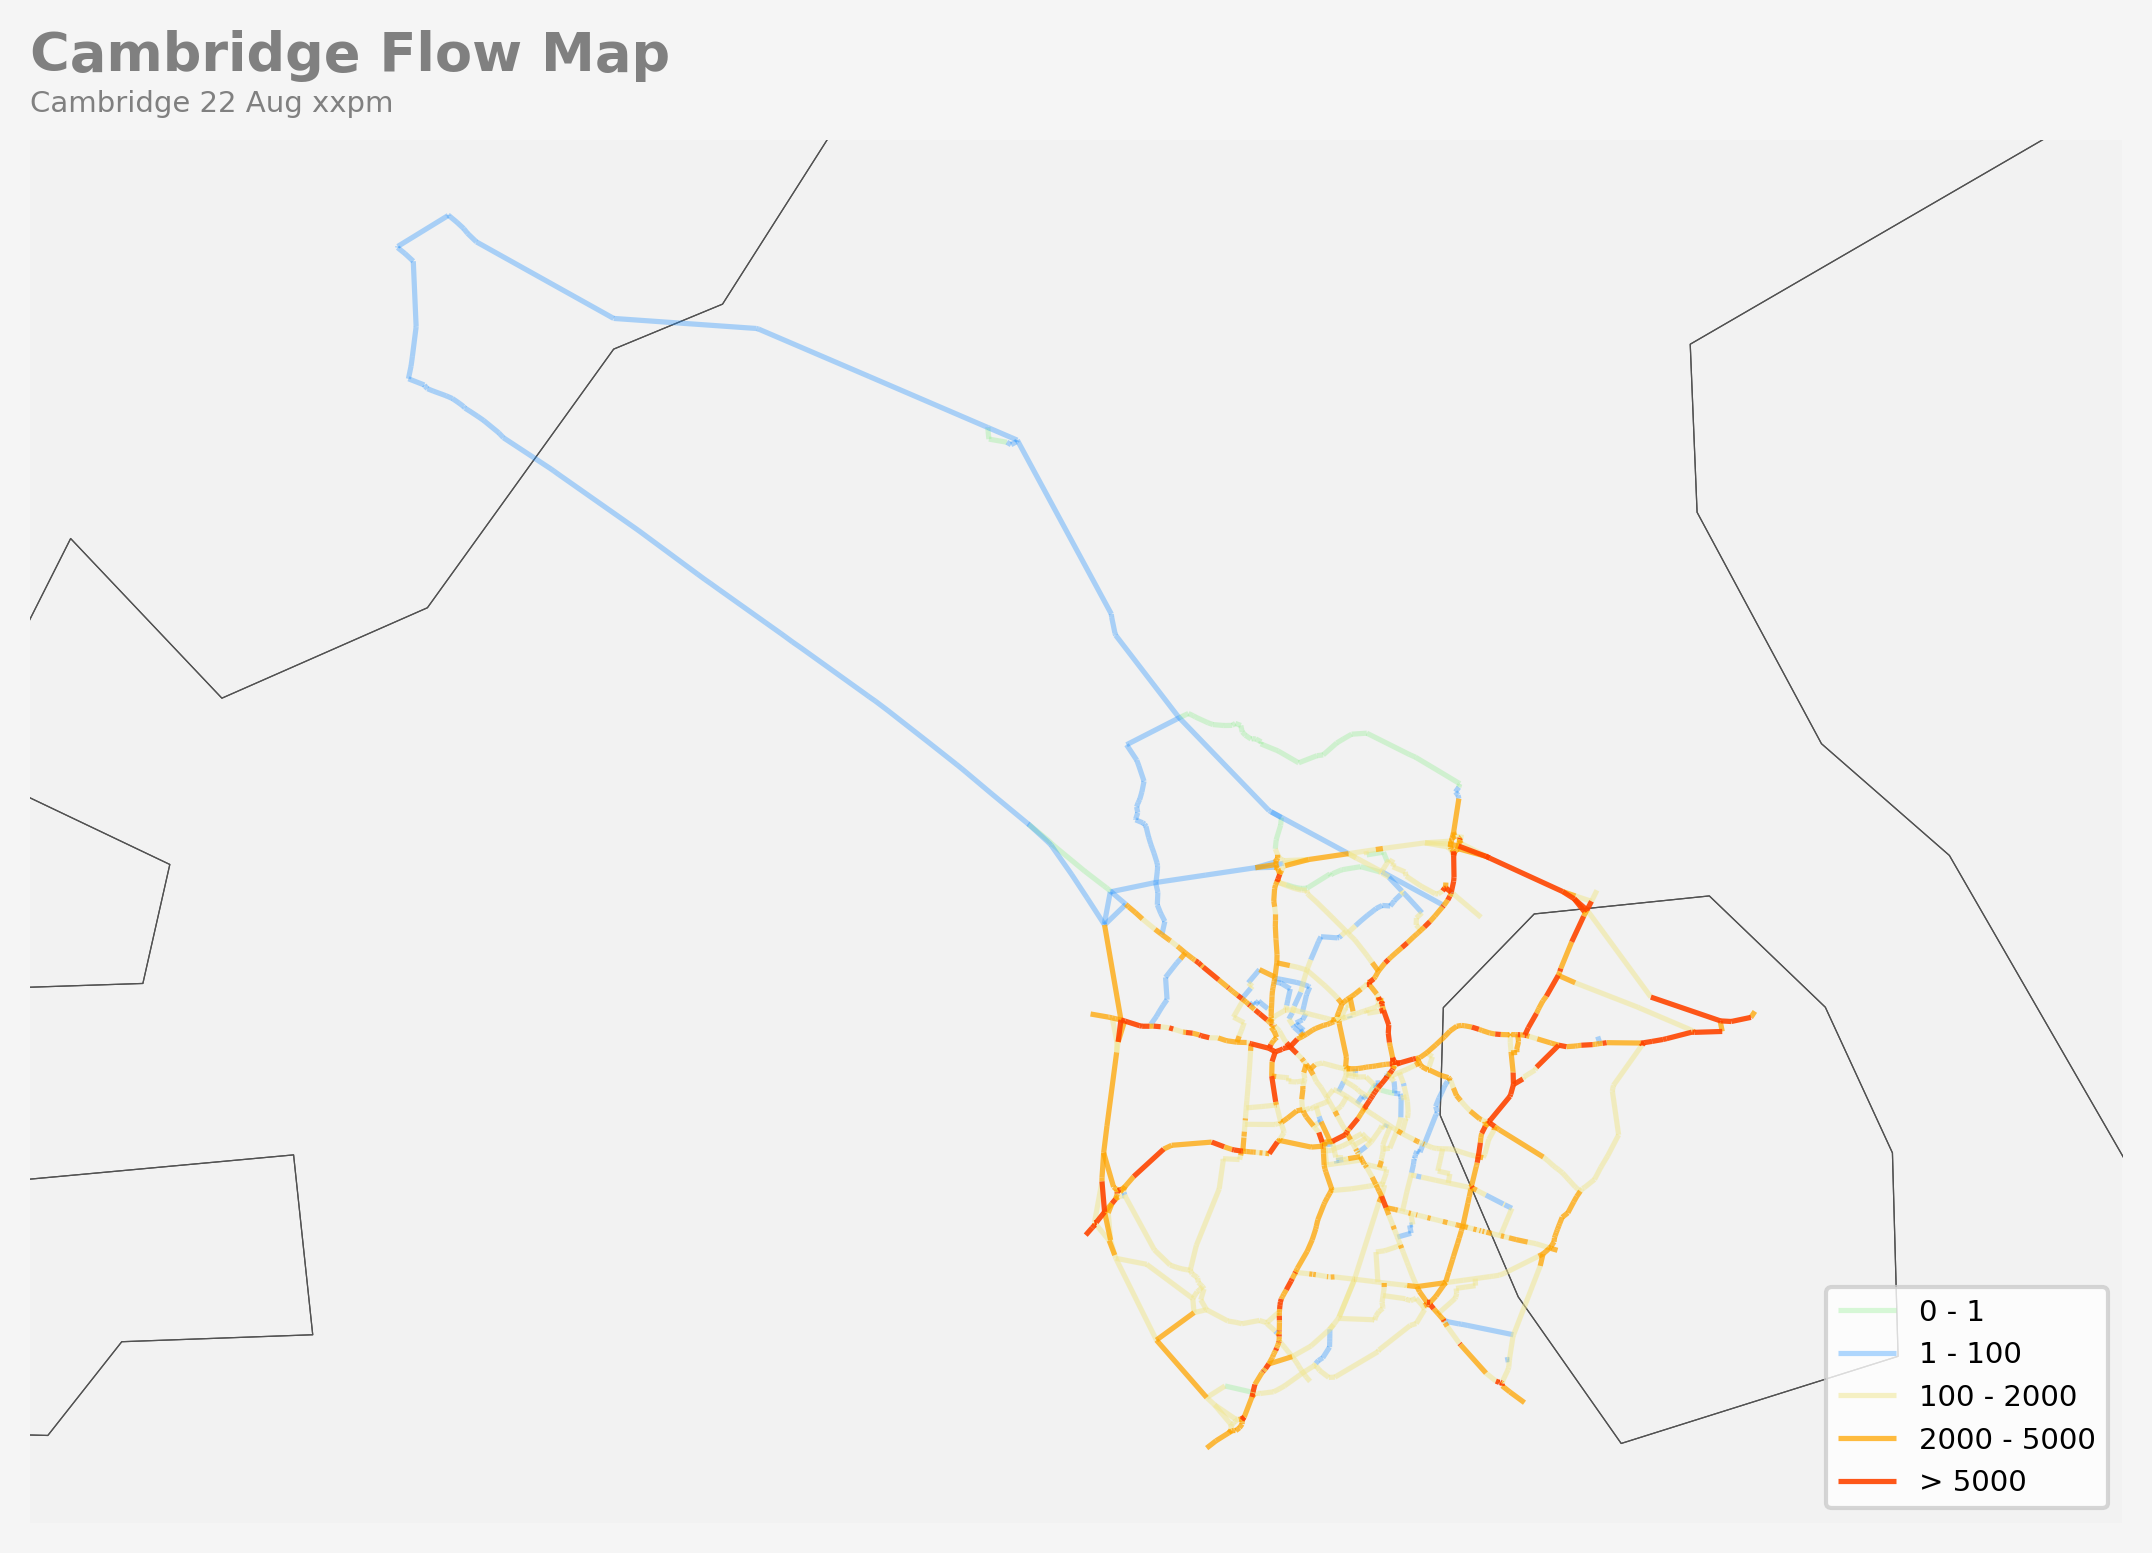

In [12]:
flow_map(title,subtitle,
         cutoff1,cutoff2,cutoff3,cutoff4,cutoff5,
         color1,color2,color3,color4,color5)

In [7]:
# df = pd.read_csv('with nodes coordinates.csv') #X: longitude, Y:latitude
# # df = df.rename(columns = {'X':'long', 'Y':'lat'})
# print(df.shape)
# df.head()

# epsg_in = 'epsg:3857'
# epsg_out = 'epsg:4326'
# inProj = Proj(init = epsg_in) 
# outProj = Proj(init= epsg_out)
# df['long'], df['lat'] = transform(inProj, outProj, df['x'].tolist(), df['y'].tolist())

# df = df.round({'Shape_Leng': 5, 'distance': 5}) #otherwise, distance can't fully == Shape_Leng
# df

In [8]:
# # x1y1 is the start point, x2y2 is the end point
# x1y1 = df.loc[df['distance']==0][['OBJECTID', 'Shape_Leng','GroupCount','long', 'lat']]
# x1y1 = x1y1.rename(columns = {'long':'coord_x1', 'lat':'coord_y1'})
# x1y1['name_x1y1'] = x1y1['OBJECTID'].astype(str) + 'a'

# x2y2 = df.loc[df['distance']==df['Shape_Leng']][['OBJECTID', 'Shape_Leng','GroupCount','long', 'lat']]
# x2y2 = x2y2.rename(columns = {'long':'coord_x2', 'lat':'coord_y2'})
# x2y2['name_x2y2'] = x2y2['OBJECTID'].astype(str) + 'b'

# df = pd.merge(x1y1, x2y2, on=['OBJECTID', 'Shape_Leng','GroupCount'])
# df = df.rename(columns = {'GroupCount':'magnitude',
#                           'Shape_Leng':'length_unit'})
# df

In [9]:
# gpd.show_versions()

In [10]:
# %load_ext watermark
# %watermark --iversions
# %watermark -v -m -p numpy,pandas,mpl_toolkits.basemap,pyproj,pyshp